In [50]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [51]:
#limiting the gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [52]:
#loading the dataset
images=tf.data.Dataset.list_files('archive (1)/Train/Train/JPEGImages\\*.jpg')


In [53]:
#function for loading
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [54]:
images = images.map(load_image)


In [55]:
#image as numpy
images.as_numpy_iterator().next()

array([[[ 41,  90, 146],
        [ 40,  89, 145],
        [ 39,  88, 146],
        ...,
        [ 47,  95, 157],
        [ 47,  95, 157],
        [ 47,  95, 157]],

       [[ 41,  90, 146],
        [ 40,  89, 145],
        [ 40,  89, 147],
        ...,
        [ 46,  94, 156],
        [ 46,  94, 156],
        [ 45,  93, 155]],

       [[ 42,  91, 147],
        [ 42,  91, 147],
        [ 41,  90, 148],
        ...,
        [ 45,  95, 156],
        [ 44,  94, 155],
        [ 43,  93, 154]],

       ...,

       [[ 36,  28,   5],
        [ 77,  69,  46],
        [111, 103,  80],
        ...,
        [ 47,  51,  16],
        [ 60,  64,  29],
        [ 48,  52,  17]],

       [[ 55,  48,  22],
        [ 57,  50,  24],
        [ 81,  74,  48],
        ...,
        [154, 158, 123],
        [ 81,  85,  50],
        [ 76,  80,  45]],

       [[104,  97,  71],
        [ 54,  47,  21],
        [ 81,  74,  48],
        ...,
        [116, 120,  85],
        [180, 184, 149],
        [ 82,  86,  51]]

In [56]:
#image graph
i_g = images.batch(1).as_numpy_iterator()

In [57]:
plot_images = i_g.next()

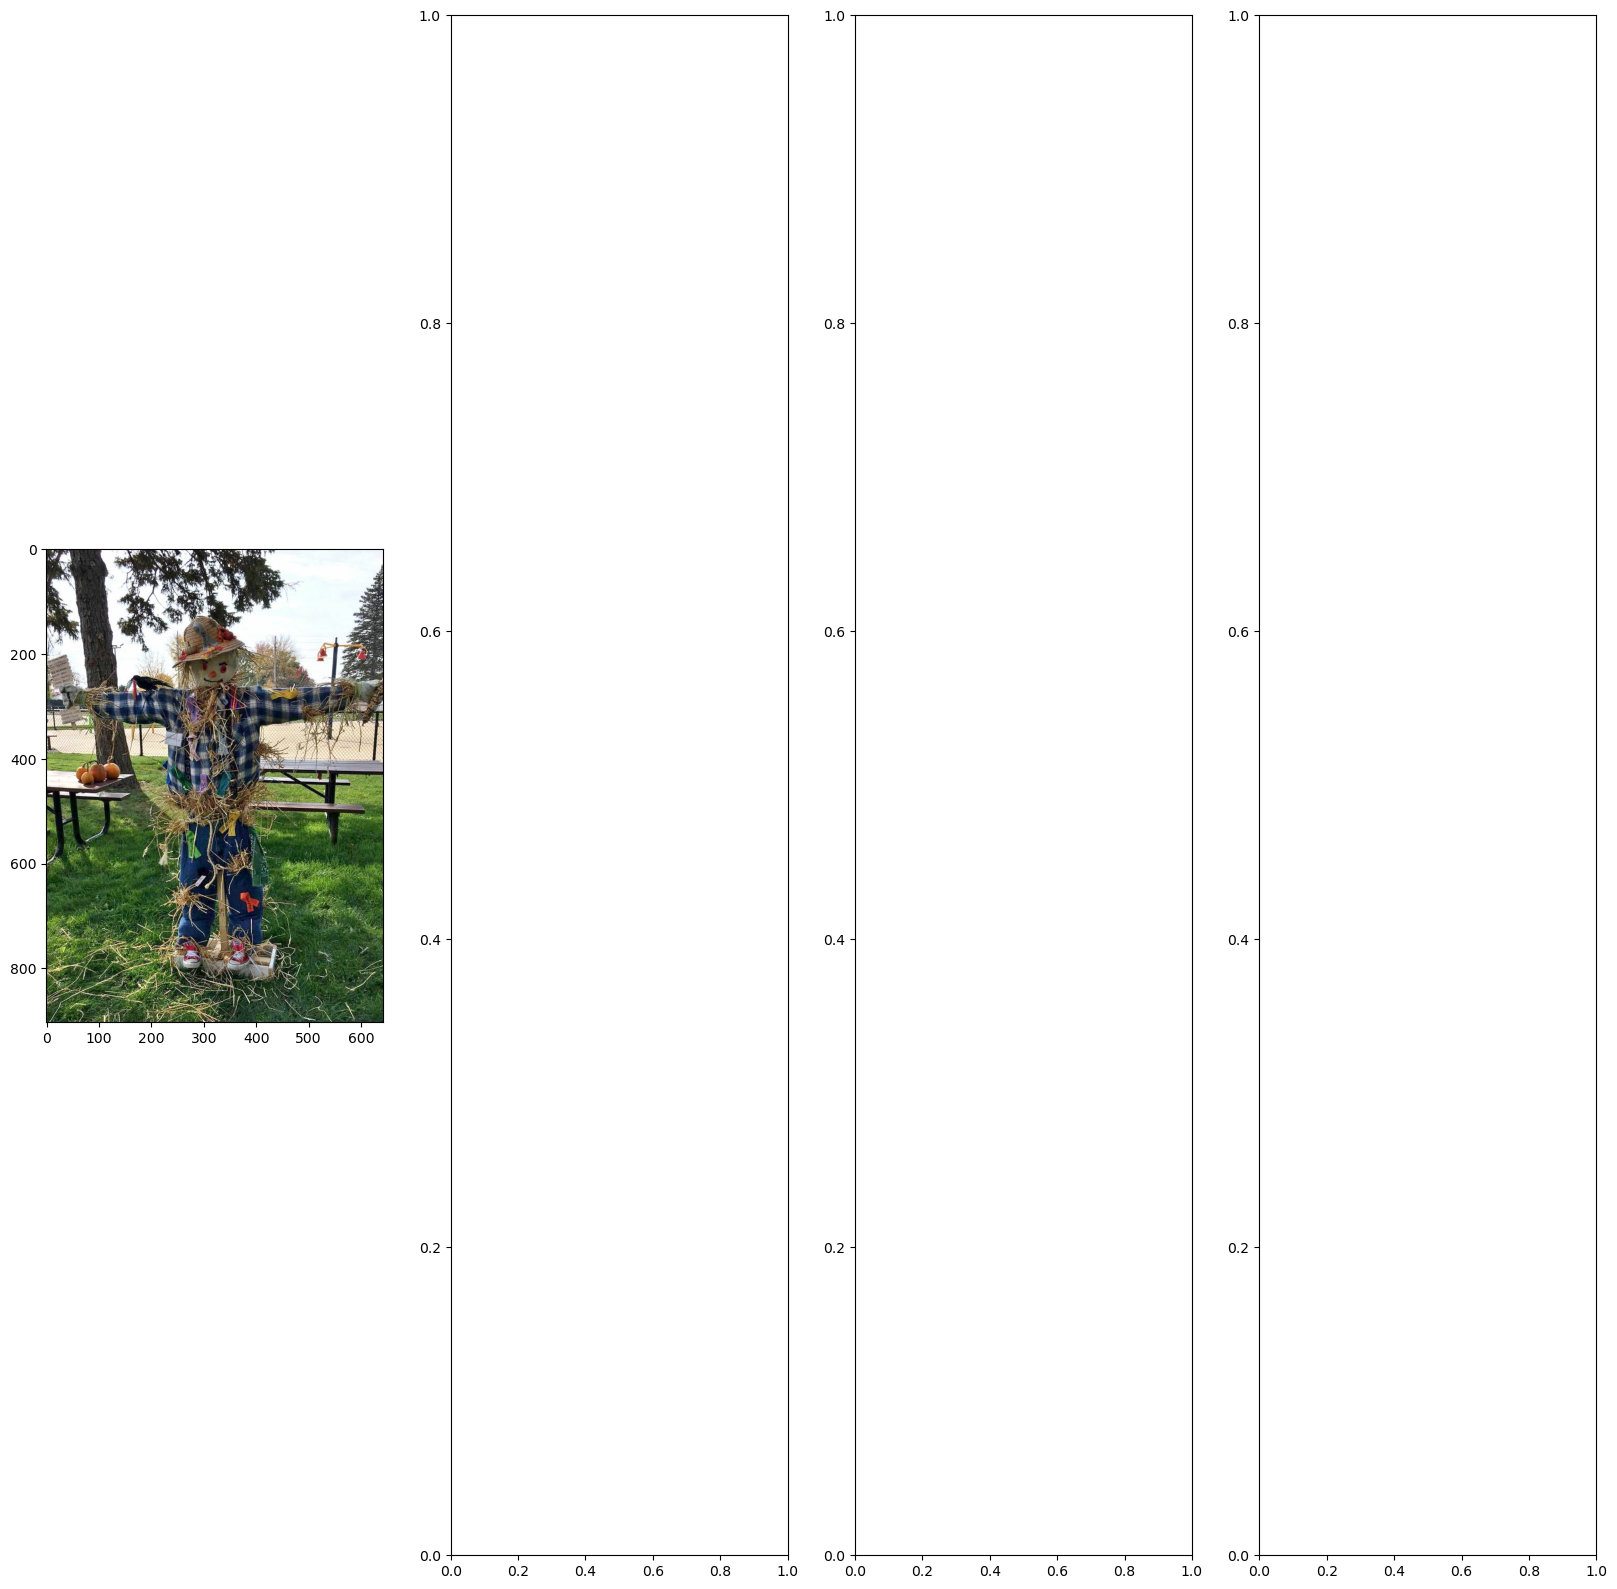

In [58]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [59]:
#tool for agumentation
import albumentations as alb

In [60]:
aug = alb.Compose([
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [61]:
#loading image 1
img = cv2.imread(os.path.join('archive (1)','train','train','JPEGImages','image (1).jpg'))

In [62]:
#minidom for reading xml file
from xml.dom import minidom

In [63]:
#loadinf first xml file
file = minidom.parse('archive (1)\Train\Train\Annotations\image (1).xml')

In [64]:
#extracting the coordinates of person
coords = [0,0,0,0]
coords[0]=file.getElementsByTagName('xmin')[0].firstChild.nodeValue
coords[1]=file.getElementsByTagName('ymin')[0].firstChild.nodeValue
coords[2]=file.getElementsByTagName('xmax')[0].firstChild.nodeValue
coords[3]=file.getElementsByTagName('ymax')[0].firstChild.nodeValue

In [65]:
#dividing by width ans height
width=file.getElementsByTagName('width')[0].firstChild.nodeValue
height=file.getElementsByTagName('height')[0].firstChild.nodeValue
coords[0]=int(coords[0])/int(width)
coords[1]=int(coords[1])/int(height)
coords[2]=int(coords[2])/int(width)
coords[3]=int(coords[3])/int(height)

In [66]:
#coordinates 
coords

[0.316, 0.09954751131221719, 0.578, 0.3778280542986425]

In [67]:
#runing augmentation function
augmented = aug(image=img, bboxes=[coords], class_labels=['pedestrain'])

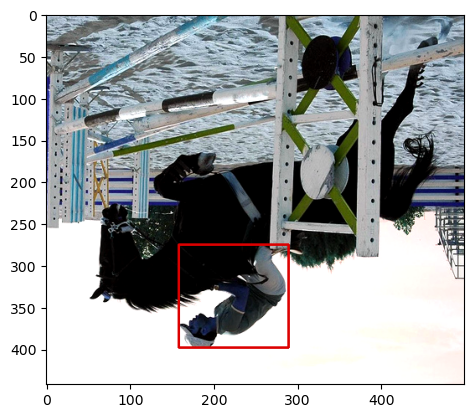

In [68]:
#puting rectangular box from coord on images
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [500,442]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [500,442]).astype(int)), 
                    (220,0,0), 2)

plt.imshow(augmented['image'])

In [31]:
for partition in ['Train','Test']: 
    for image in os.listdir(os.path.join('archive (1)', partition, partition, 'JPEGImages')):
        img = cv2.imread(os.path.join('archive (1)', partition, partition, 'JPEGImages', image))

        coords = [0,0,0.00001,0.00001]
        file = minidom.parse(fr'archive (1)\{partition}\{partition}\Annotations\{image.split(".")[0]}.xml')
        coords[0]=file.getElementsByTagName('xmin')[0].firstChild.nodeValue
        coords[1]=file.getElementsByTagName('ymin')[0].firstChild.nodeValue
        coords[2]=file.getElementsByTagName('xmax')[0].firstChild.nodeValue
        coords[3]=file.getElementsByTagName('ymax')[0].firstChild.nodeValue
        width=file.getElementsByTagName('width')[0].firstChild.nodeValue
        height=file.getElementsByTagName('height')[0].firstChild.nodeValue
        coords[0]=int(coords[0])/int(width)
        coords[1]=int(coords[1])/int(height)
        coords[2]=int(coords[2])/int(width)
        coords[3]=int(coords[3])/int(height)

        try: 
            for x in range(10):
                augmented = aug(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                ann= {}
                ann['image'] = image

                if os.path.exists(1):
                    if len(augmented['bboxes']) == 0: 
                        ann['bbox'] = [0,0,0,0]
                        ann['class'] = 0 
                    else: 
                        ann['bbox'] = augmented['bboxes'][0]
                        ann['class'] = 1
                else: 
                    ann['bbox'] = [0,0,0,0]
                    ann['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(ann, f)

        except Exception as e:
            print(e)

ZeroDivisionError: division by zero

In [69]:
#loading the train images
tr_i = tf.data.Dataset.list_files('aug_data\\Train\\images\\*.jpg', shuffle=False)
tr_i = tr_i.map(load_image)
tr_i = tr_i.map(lambda x: tf.image.resize(x, (120,120)))
tr_i = tr_i.map(lambda x: x/255)
#loading the test images
test_imag = tf.data.Dataset.list_files('aug_data\\Test\\images\\*.jpg', shuffle=False)
test_imag = test_imag.map(load_image)
test_imag = test_imag.map(lambda x: tf.image.resize(x, (120,120)))
test_imag = test_imag.map(lambda x: x/255)

tr_i.as_numpy_iterator().next()

array([[[0.79617643, 0.80849946, 0.97062093],
        [0.800098  , 0.8132026 , 0.9699673 ],
        [0.8049346 , 0.81803924, 0.974804  ],
        ...,
        [0.99978495, 1.        , 0.99215686],
        [0.9974183 , 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ]],

       [[0.8135539 , 0.8292402 , 0.97433823],
        [0.80803925, 0.8237255 , 0.96882355],
        [0.8121732 , 0.82785946, 0.9657516 ],
        ...,
        [1.        , 1.        , 0.99215686],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.81062096, 0.82630724, 0.97532684],
        [0.8080066 , 0.82369286, 0.96977127],
        [0.8106209 , 0.8263072 , 0.9714052 ],
        ...,
        [0.9964051 , 1.        , 0.99215686],
        [1.        , 1.        , 1.        ],
        [0.9937908 , 1.        , 0.9977124 ]],

       ...,

       [[0.67961544, 0.63208014, 0.55428886],
        [0.6086982 , 0.58071625, 0.51899254],
        [0.3943617 , 0

In [33]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [34]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
len(tr_i), len(train_labels), len(test_imag), len(test_labels)

(9440, 9440, 870, 870)

In [39]:
train = tf.data.Dataset.zip((tr_i, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_imag, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [40]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.178   , 0.1914  , 0.73    , 1.      ],
        [0.048   , 0.05554 , 0.556   , 1.      ],
        [0.234   , 0.192   , 0.806   , 1.      ],
        [0.5     , 0.3093  , 0.926   , 1.      ],
        [0.512   , 0.2837  , 0.8257  , 0.8926  ],
        [0.002   , 0.      , 0.604   , 0.992   ],
        [0.49    , 0.248   , 0.998   , 0.9976  ],
        [0.002762, 0.      , 0.533   , 0.988   ]], dtype=float16))

In [41]:
data_samples = train.as_numpy_iterator()

In [42]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


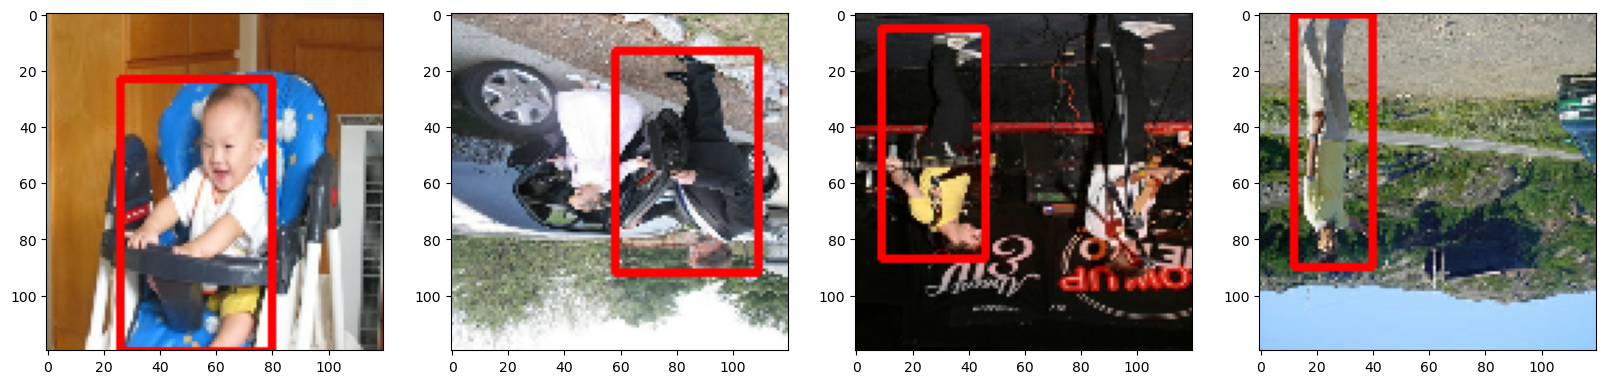

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [45]:
vgg = VGG16(include_top=False)

In [46]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [47]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [48]:
facetracker = build_model()

In [49]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  